In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Initial exploration
## Loading the dataset

In [2]:
DATAPATH = "data/churn-data.csv"

df = pd.read_csv(DATAPATH)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Eliminating redundant information
The intention is to strip the dataset out of any unnecessary pieces of data that only clutter the analysis.
Then, we will go column by column and attempt to estabish some domain truth..

### `RowNumber`

In [5]:
assert np.all(df["RowNumber"] - 1 == df.index)

We can eliminate.

### `CustomerId`

In [6]:
assert df["CustomerId"].unique().shape[0] == len(df)

Unique identifier. Good.

### `CustomerId` vs `Surname`

In [7]:
df[["CustomerId", "Surname"]] \
    .groupby("Surname") \
    .count() \
    .rename(columns={"CustomerId": "count"}) \
    .sort_values(by="count", ascending=False) \
    .head()

,count
Surname,
Smith,32
Martin,29
Scott,29
Walker,28
Brown,26


OK, the surname is not unique, but either way it does not bear out any information, unless we want to eradicate all Smiths...
We'll eliminate the `Surname` too.

### `CreditScore`

In [8]:
df["CreditScore"].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

<AxesSubplot:>

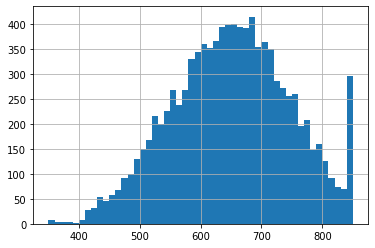

In [9]:
df["CreditScore"].hist(bins=50)

This is useful. Especially the anomaly at the right end of the distribution. It may possibly indicate some high-profile customers.

### `Geography`

In [10]:
df["Geography"].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

This column is perfect. Pure cateorical data and very clean.

### `Gender`

In [11]:
df["Gender"].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

Ditto.

### `Age`

<AxesSubplot:>

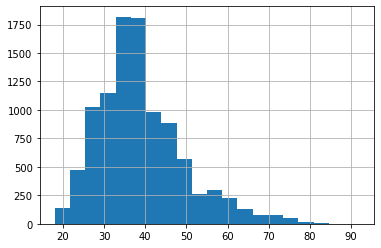

In [12]:
df["Age"].hist(bins=20)

It's OK by the looks of it. No anomalies such as negative age or 150+ y.o. grandmothers.

### `Tenure`

<AxesSubplot:>

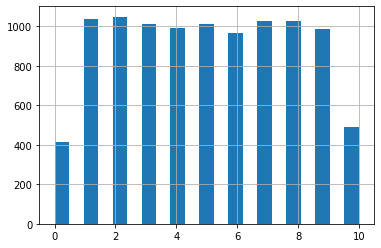

In [13]:
df["Tenure"].hist(bins=21)

An interesting thing goes on here! It's an almost uniform distribution.
However, I would expect an exponentially decaying one, with sort of halving rate every X years.
Still, it seems that:
* the dataset has an almost equal representation of all tenures, which is strange - no tenure dominates...
* the tenure drops after 10 years, which suggest that either the data was collected at a certain point in time and did not account for earlier entires (and this is again strange) or the bank offers e.g. 10-year loans, after which people just go...

### `Balance`

<AxesSubplot:>

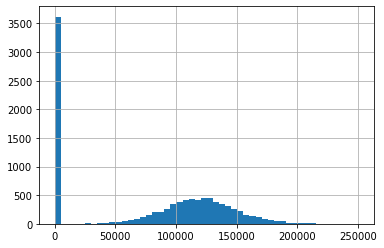

In [14]:
df["Balance"].hist(bins=50)

This is very interesting. We have an mixture of an Gaussian-like distribution when it comes to the balance and a spike of customers with no money at all.
There is no representation for a negative balance, which may actually be hidden from the data (e.g. a different column called "dept").

### `NumOfProducts`

In [15]:
df["NumOfProducts"].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

I am not sure what the "products" are, but I suspect they may be loans, credit cards, and similar.
Either way, the data is categorical with every customer having at least one product. Makes sense. An open account is a product.

### `HasCrCard`

In [16]:
df["HasCrCard"].value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

OK. Intuitive, True/False.

### `IsActiveMember`

In [17]:
df["IsActiveMember"].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

I am not sure what it means that a customer is "active". Is that related to voluntary/involuntary churn?
In real, I would definitely address this question.

### `EstimatedSalary`

<AxesSubplot:>

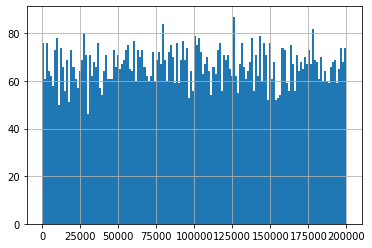

In [18]:
df["EstimatedSalary"].hist(bins=150)

This is a uniform distribution, which suggests there are no "preferred" customers in this bank. For example, it's not an elite banking service that accepts people of more than millon USD, and it's not "Bocian". A normal bank.

### `Exited`  - the label

In [19]:
df["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

The dataset is, what we can expect, skewed. Almost 80% of the customers are the ones that haven't churned,
although just the fact that they haven't churned doesn't mean they are not planning to do so.

## Cleaning the dataset
As we have no outliers, ununiform data (e.g. lower/upper, space/no-space, etc.), there is not much cleaning.
We can still remove:
- `RowNumber` - completely redundant
- `Surname` - does not contain any useful information

The rest we will keep and process them to become features.

In [20]:
X_raw = df.drop(columns=["RowNumber", "Surname"]).set_index("CustomerId")
y_raw = df.get(["CustomerId", "Exited"]).set_index("CustomerId")
X_raw = X_raw.drop(columns=["Exited"])

X_raw.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
CustomerId,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,1,1,101348.88
15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57
15701354,699,France,Female,39,1,0.00,2,0,0,93826.63
15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [21]:
y_raw.head()

,Exited
CustomerId,
15634602,1
15647311,0
15619304,1
15701354,0
15737888,0


### Numeric features

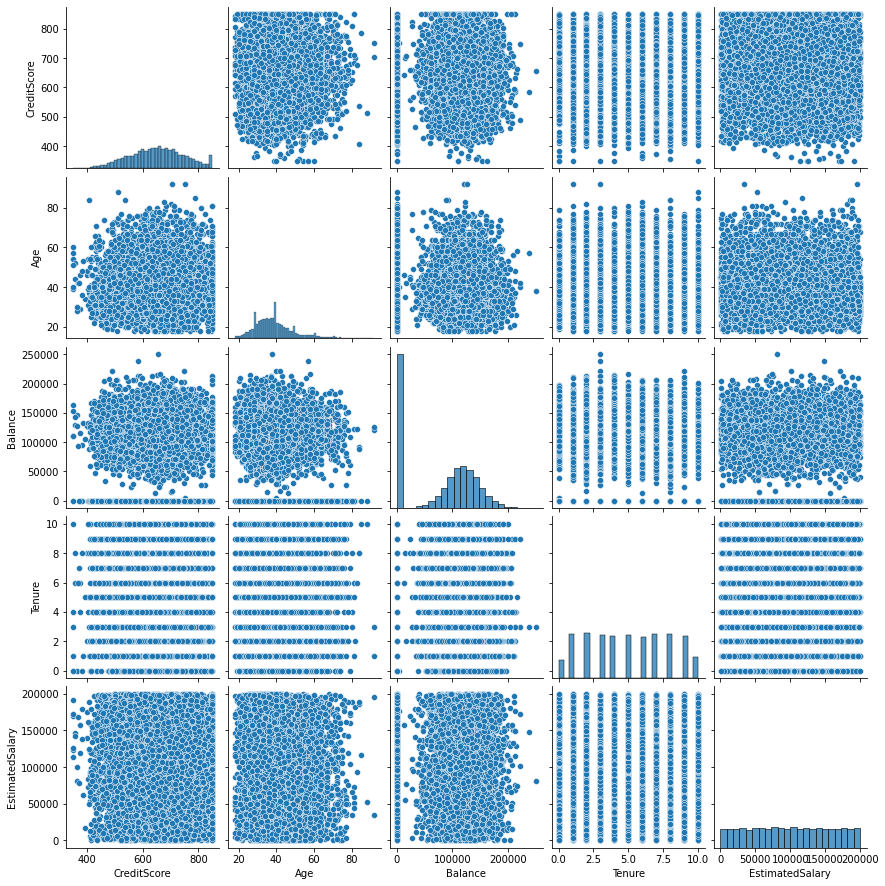

In [22]:
NUMERIC_FEATURES = ["CreditScore", "Age", "Balance", "Tenure", "EstimatedSalary"]

sns.pairplot(X_raw[NUMERIC_FEATURES])

In [23]:
X_raw[NUMERIC_FEATURES].corr()

,CreditScore,Age,Balance,Tenure,EstimatedSalary
CreditScore,1.000000,-0.003965,0.006268,0.000842,-0.001384
Age,-0.003965,1.000000,0.028308,-0.009997,-0.007201
Balance,0.006268,0.028308,1.000000,-0.012254,0.012797
Tenure,0.000842,-0.009997,-0.012254,1.000000,0.007784
EstimatedSalary,-0.001384,-0.007201,0.012797,0.007784,1.000000


### Categorical features

In [24]:
CATEGORICAL_FEATURES = ["Geography", "Gender", "NumOfProducts", "HasCrCard", "IsActiveMember"]

X_raw[CATEGORICAL_FEATURES]

,Geography,Gender,NumOfProducts,HasCrCard,IsActiveMember
CustomerId,,,,,
15634602,France,Female,1,1,1
15647311,Spain,Female,1,0,1
15619304,France,Female,3,1,0
15701354,France,Female,2,0,0
15737888,Spain,Female,1,1,1
...,...,...,...,...,...
15606229,France,Male,2,1,0
15569892,France,Male,1,1,1
15584532,France,Female,1,0,1


### Mutual Correlation

In [25]:
_X_raw = X_raw \
    .corr() \
    .unstack() \
    .reset_index() \
    .rename(columns={"level_0": "v1", "level_1": "v2", 0: "correlation"})
_X_raw["correlation"] = np.abs(_X_raw["correlation"])
_X_raw = _X_raw \
    .sort_values(by="correlation", ascending=False) \
    .query("v1 != v2") \
    .drop_duplicates(subset="correlation") \
    .rename(columns={"correlation": "abs_correlation"})

_X_raw.head(15)

,v1,v2,abs_correlation
28,Balance,NumOfProducts,0.304180
14,Age,IsActiveMember,0.085472
33,NumOfProducts,Age,0.030680
50,IsActiveMember,Tenure,0.028362
25,Balance,Age,0.028308
48,IsActiveMember,CreditScore,0.025651
21,Tenure,HasCrCard,0.022583
29,Balance,HasCrCard,0.014858
39,NumOfProducts,EstimatedSalary,0.014204
20,Tenure,NumOfProducts,0.013444


The correlation is very weak everywhere, which suggests we have equal representation of all "groups" (e.g. rich people but in debt, old people that save, etc.).
The highest correlation occurs between `Balance` and `NumOfProducts` (and it's negative), which suggest that the higher the number of products the less people have on their bank account, which... makes sense.

Based on these observations, we don't eliminate any more features.

## Relevance to the label
### Comparing unnormalized distributions

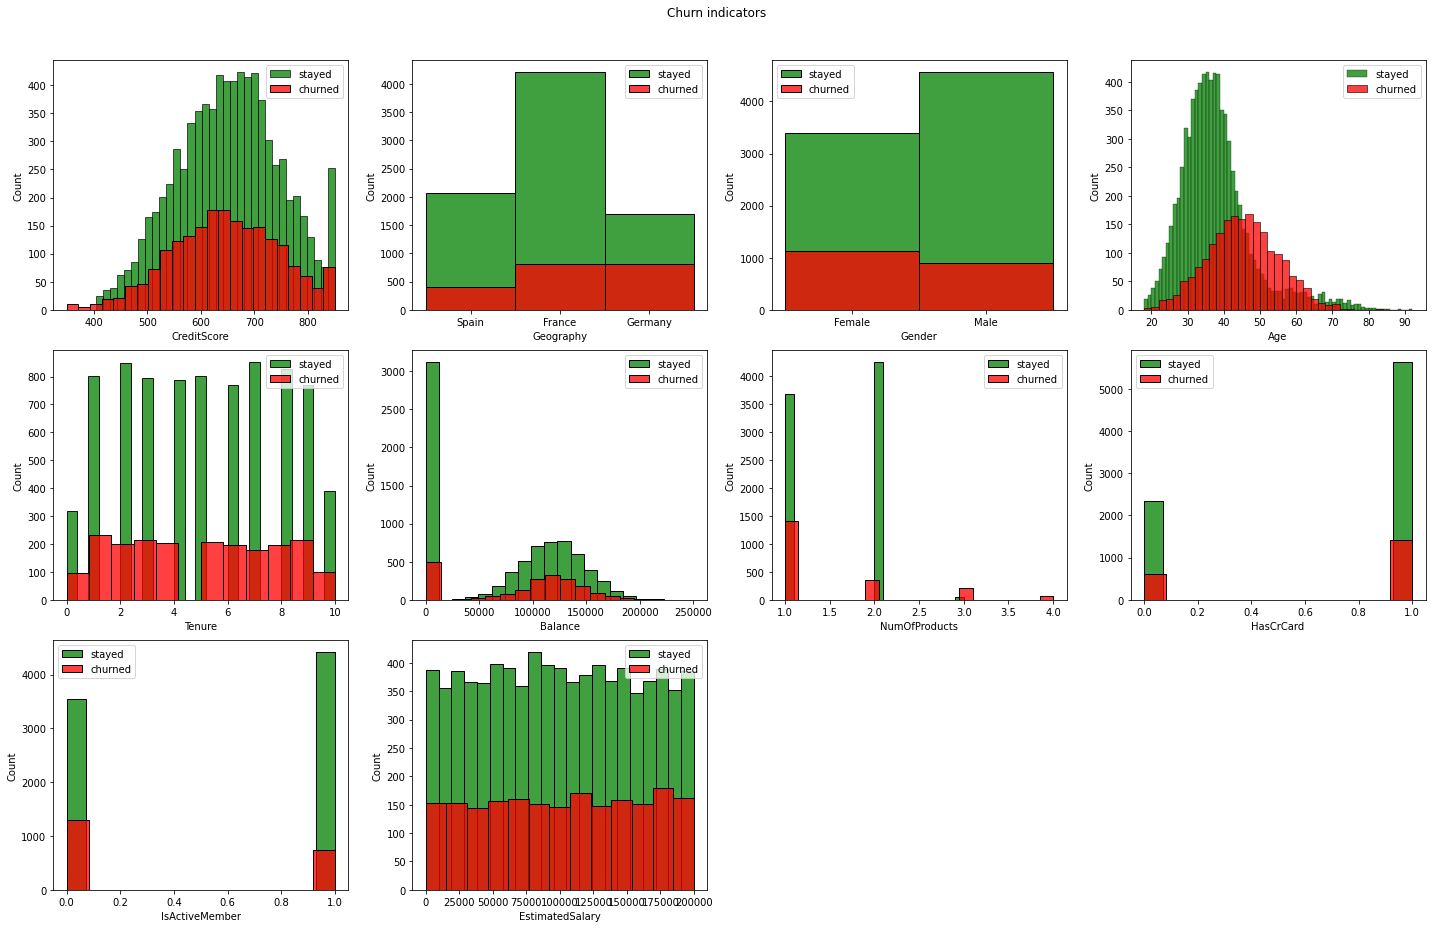

In [26]:
fig = plt.figure(figsize = (20, 25))
j = 0
for column in X_raw.columns:
    plt.subplot(6, 4, j + 1)
    j += 1
    sns.histplot(X_raw.query("@y_raw.Exited == 0"), x=column, color='g', label = 'stayed')
    sns.histplot(X_raw.query("@y_raw.Exited == 1"), x=column, color='r', label = 'churned')
    plt.legend(loc='best')
fig.suptitle("Churn indicators")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Comparing normalized distributions
Here, I undersample the not-churned dataset to have an orientation about the changes between the two groups.
For that the groups need to be of a comparible size.

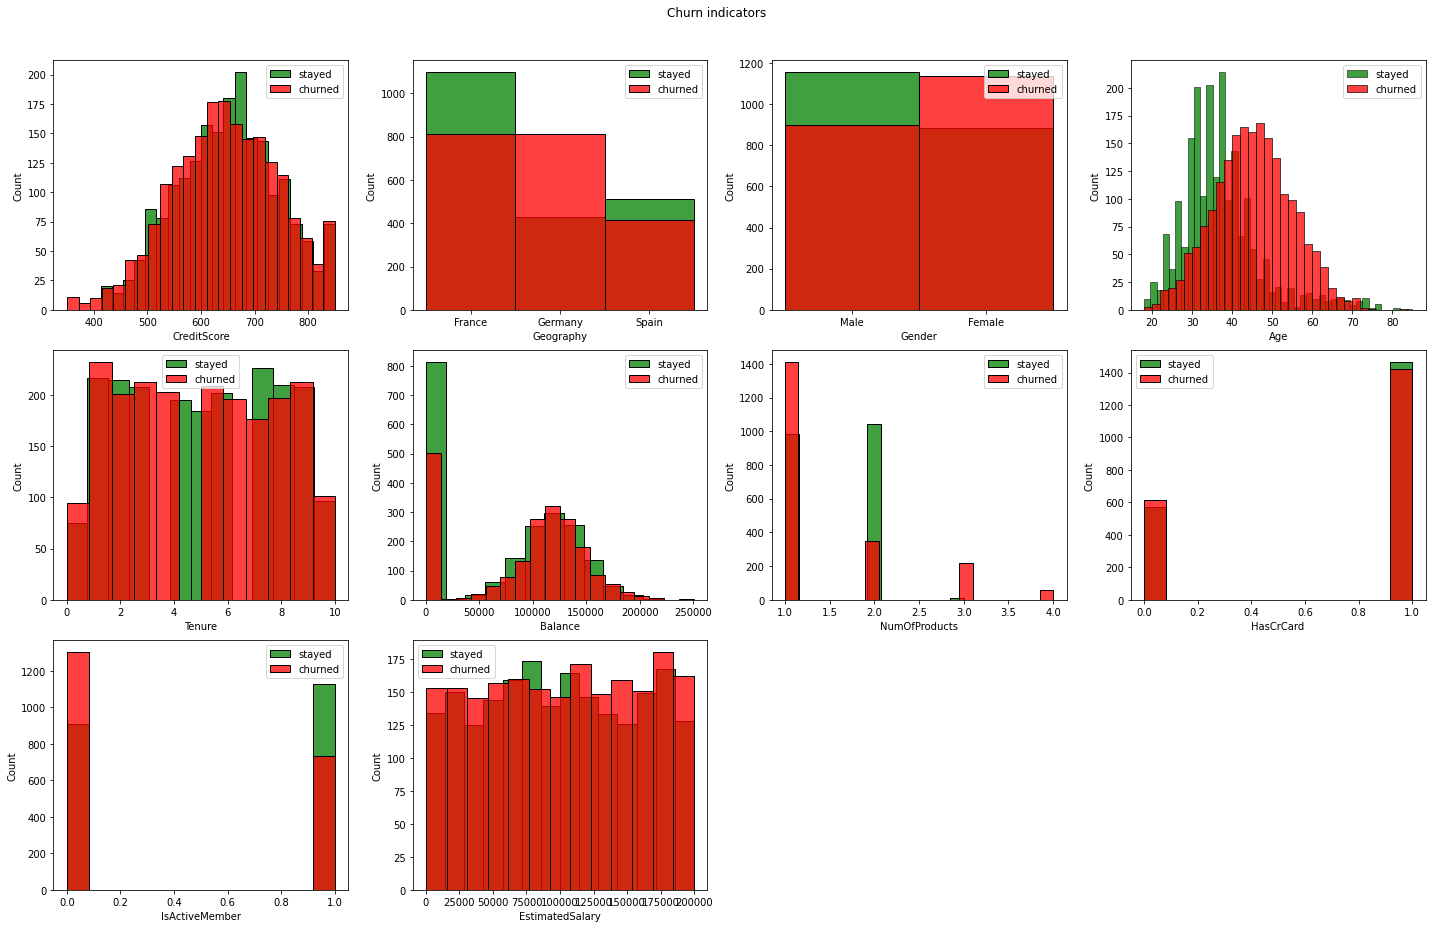

In [27]:
churn_count = y_raw["Exited"].sum()

fig = plt.figure(figsize = (20, 25))
j = 0
for column in X_raw.columns:
    plt.subplot(6, 4, j + 1)
    j += 1
    sns.histplot(X_raw.query("@y_raw.Exited == 0").sample(churn_count), x=column, color='g', label = 'stayed')
    sns.histplot(X_raw.query("@y_raw.Exited == 1"), x=column, color='r', label = 'churned')
    plt.legend(loc='best')
fig.suptitle("Churn indicators")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

When undersampling, there is always an error related to picking the wrong sample.
Still, we can see that the labels (churn) is more sensitive to certain features more than others.

Especially promising features include:
- Geography
- Gender
- Age
- Balance (but more conditioned on the lower-income group)
- numer of products
- and the mysterious active membershup

Conversely, there is no significant indicator for:
- credit score
- balance
- having a credit card
- salary

This strongly suggests that the churn is more dependent on demographic features rather than financial (pro tip for business).

## Saving the raw data

In [28]:
X_raw.to_pickle("data/X_raw.pkl")
y_raw.to_pickle("data/y_raw.pkl")